# Goal:
In this file, we aim to make $$\hat{f(x)}\thickapprox f(x), \frac{d\hat{f(x)}}{dx}\thickapprox f'(x)$$
at the same time.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Setting
- dataset: sampling method (uniform random over [-1, 1])
- dataset size:
    - training set: 256
    - validation set: 256
    - test set: 1000
- Neurak network architecture:
    - hidden layers: 2
    - nonlinear function: tanh
    - tanh units: 64
- optimizer: Adam
- learning rate: $2e-3$
- weight decay: $1e-5$
- epoches: 800
- Loss metric: MSE

In [12]:
# ---------- config ----------
seed = 42
n_train, n_val, n_test = 256, 256, 1000
hidden = 64
lr = 2e-3
weight_decay = 1e-5
epochs = 800
patience = 80
device = "cpu"

# ---------- utils ----------
torch.manual_seed(seed)
np.random.seed(seed)

def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)



In [13]:
# dataset 
def chebyshev_nodes(n):
    k = np.arange(1, n+1)
    return np.cos((2*k - 1) / (2*n) * np.pi).reshape(-1,1)
x_train=chebyshev_nodes(n_train)
y_train=f(x_train)
x_val=chebyshev_nodes(n_val)
y_val=f(x_val)
x_test=np.linspace(-1.0, 1.0, n_test).reshape(-1,1)
y_test=f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,h), nn.Tanh(),
            nn.Linear(h,h), nn.Tanh(),
            nn.Linear(h,1)
        )
    def forward(self, x): 
        return self.net(x)

model = MLP(hidden).to(device)




In [22]:
def fprime(x: torch.Tensor):
    return (-50.0 * x / (1.0 + 25.0 * x**2)**2).detach()

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
lambda_d = 1.0  # 0.1~10

train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
since_best = 0
patience = 80  

for ep in range(1, epochs+1):
    # ===== Train =====
    model.train()
    epoch_train_f = 0.0
    epoch_train_d = 0.0
    nbatch = 0

    for xb, yb in train_dl:
        xb = xb.detach().clone().requires_grad_(True)
        y_true = yb

        # forward
        y_pred = model(xb)

        dy_dx = torch.autograd.grad(
            outputs=y_pred,
            inputs=xb,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,    
            #retain_graph=False,
            #only_inputs=True
        )[0]

        # losses
        loss_f = loss_fn(y_pred, y_true)
        loss_d = loss_fn(dy_dx, fprime(xb))
        loss = loss_f + lambda_d * loss_d

        opt.zero_grad()
        loss.backward()           
        opt.step()

        epoch_train_f += loss_f.item()
        epoch_train_d += loss_d.item()
        nbatch += 1

    # 平均一下
    train_f = epoch_train_f / nbatch
    train_d = epoch_train_d / nbatch
    train_total = train_f + lambda_d * train_d

    # ===== Validate =====
    model.eval()

    toggled = []
    for p in model.parameters():
        if p.requires_grad:
            p.requires_grad_(False)
            toggled.append(p)

    xv = Xva.detach().clone().requires_grad_(True)
    y_pred_v = model(xv)

    dv = torch.autograd.grad(
        outputs=y_pred_v,
        inputs=xv,
        grad_outputs=torch.ones_like(y_pred_v),
        create_graph=False,
        retain_graph=False,
        only_inputs=True
    )[0]

    val_loss_f = loss_fn(y_pred_v, Yva).item()
    val_loss_d = loss_fn(dv, fprime(xv)).item()
    val_loss = val_loss_f + lambda_d * val_loss_d

    for p in toggled:
        p.requires_grad_(True)

    train_losses.append(train_total)
    val_losses.append(val_loss)

    # ===== Early stopping tracking =====
    if val_loss < best_val - 1e-7:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            # print(f"Early stopped at epoch {ep}")
            break

# ===== Restore best =====
if best_state is not None:
    model.load_state_dict(best_state)

# ===== Evaluate on test (function) =====
model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()
mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")


Xte_grad = Xte.detach().clone().requires_grad_(True)
y_pred_te = model(Xte_grad)
dte = torch.autograd.grad(y_pred_te, Xte_grad, torch.ones_like(y_pred_te))[0]
mse_d = float(nn.MSELoss()(dte, fprime(Xte_grad)).item())
max_err_d = float(torch.max(torch.abs(dte - fprime(Xte_grad))).item())
print(f"Test Derivative MSE      : {mse_d:.6e}")
print(f"Test Derivative Max |err|: {max_err_d:.6e}")


Test MSE      : 4.928043e-07
Test Max |err|: 9.919449e-04
Test Derivative MSE      : 8.425584e-06
Test Derivative Max |err|: 9.213328e-03


### Loss curve

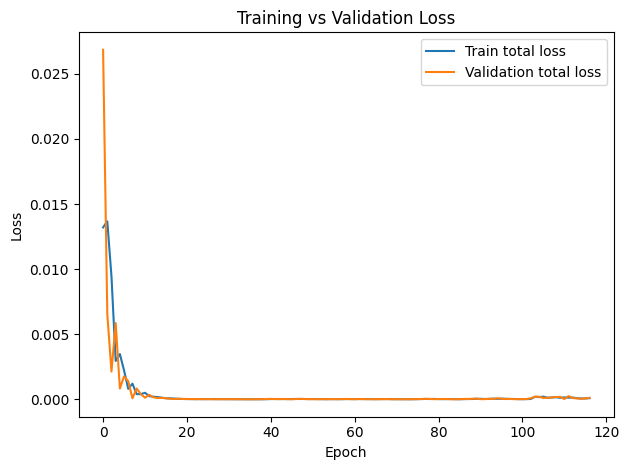

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Train total loss")
plt.plot(val_losses, label="Validation total loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


### Function approximation

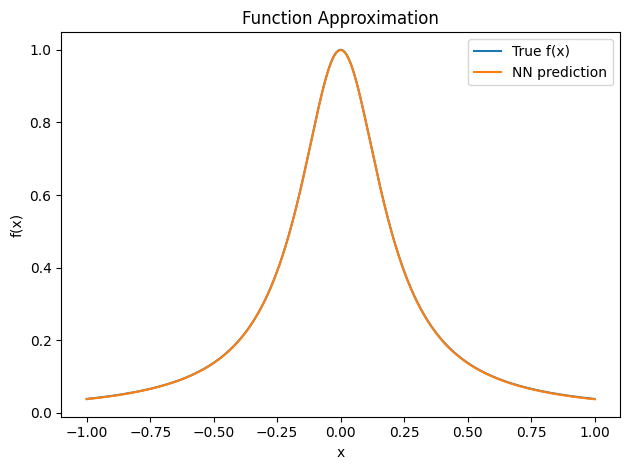

In [24]:
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function Approximation")
plt.legend()
plt.tight_layout()
plt.show()



### Derivative approximation

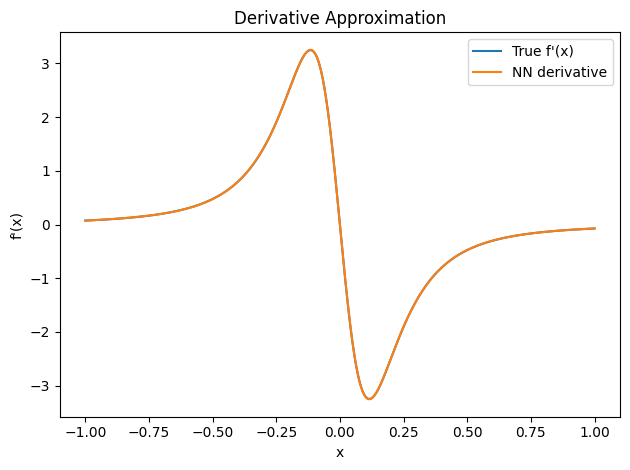

In [25]:
# NN derivatve
Xte_grad = Xte.detach().clone().requires_grad_(True)
y_pred_te = model(Xte_grad)
dte = torch.autograd.grad(y_pred_te, Xte_grad, torch.ones_like(y_pred_te))[0]
dte = dte.detach().cpu().numpy()

plt.figure()
plt.plot(x_test.ravel(), fprime(torch.tensor(x_test)).numpy(), label="True f'(x)")
plt.plot(x_test.ravel(), dte.ravel(), label="NN derivative")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.title("Derivative Approximation")
plt.legend()
plt.tight_layout()
plt.show()
